In [1]:
import solver
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
def compare_num_to_analytic(
                            radius=10, velocity=20e3, density=3000, strength=1e5, angle=45,
                            init_altitude=1e5, radians=False):
    
    input_data = {'radius': radius,
              'velocity': velocity,
              'density': density,
              'strength': strength,
              'angle': angle,
              'init_altitude': init_altitude,
              'radians': radians}

    z0 = input_data['init_altitude']  # entry altitude
    th0 = input_data['angle'] * np.pi/180  # entry angle
    v0 = input_data['velocity']  # entry velocity
    r = input_data['radius']  # object radius
    rhom = input_data['density']  # object density
    m = (4/3) * np.pi * r**3 * rhom  # object mass
    A = np.pi * r**2  # object cross-sectional area

    planet = solver.Planet(Cd=1., Ch=0, Q=1, Cl=0, alpha=0,
                           Rp=np.inf, g=0, H=8000., rho0=1.2)
    result = planet.solve_atmospheric_entry(**input_data)

    ts_list = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

    numerical_error = []
    for time_step in ts_list:
        results = planet.solve_atmospheric_entry(**input_data, ts=time_step, dt=time_step)
        height_n = results.altitude.values
        velocity_n = results.velocity.values

        # define a constant in the solution
        x = planet.H * (-planet.Cd * A / (2*m) * planet.rho0 / np.sin(th0))

        # analytical solution gives v as a function of z
        z = height_n
        velocity_a = v0 * \
            (np.exp(x * (np.exp(-z/planet.H) - np.exp(-z0/planet.H))))

        e = np.abs(velocity_a[-1] - velocity_n[-1])
        numerical_error.append(e)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.loglog(ts_list, numerical_error, 'b.', markersize=12, label='RK4')
    ax.set_xlabel('Time Step (s)')
    ax.set_ylabel('Error')

    start_fit = 2
    end_fit = -3
    line_fit = np.polyfit(np.log(ts_list[start_fit:end_fit]), np.log(
        numerical_error[start_fit:end_fit]), 1)
    ax.loglog(ts_list, np.exp(line_fit[1]) * ts_list**(line_fit[0]),
              'k-', label='slope: {:.2f}'.format(line_fit[0]))
    ax.legend(loc='best')
    plt.show()

In [3]:
# New planet comparison with solve_ivp

def compare_with_scipy(
                    radius=10, velocity=20e3, density=3000, strength=1e5, angle=45, init_altitude=1e5, 
                    radians=False, ts_list=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
                    alpha=0, tol=1e-6):

    input_data = {'radius': radius,
              'velocity': velocity,
              'density': density,
              'strength': strength,
              'angle': angle,
              'init_altitude': init_altitude,
              'radians': radians}

    z0 = input_data['init_altitude']  # entry altitude
    th0 = input_data['angle'] * np.pi/180  # entry angle
    v0 = input_data['velocity']  # entry velocity
    r = input_data['radius']  # object radius
    rhom = input_data['density']  # object density
    m = (4/3) * np.pi * r**3 * rhom  # object mass
    A = np.pi * r**2  # object cross-sectional area

    planet_nofrag = solver.Planet(alpha=0)
    planet_frag = solver.Planet(alpha=alpha)

    radius = input_data['radius']
    velocity = input_data['velocity']
    density = input_data['density']
    strength = input_data['strength']
    angle = input_data['angle']
    init_altitude = input_data['init_altitude']
    radians = input_data['radians']

    # initial condition
    v0 = velocity
    m0 = (4/3) * np.pi * radius**3 * density
    if radians:
        theta0 = angle
    else:
        theta0 = angle * np.pi / 180

    z0 = init_altitude
    x0 = 0
    r0 = radius
    state0 = np.array([v0, m0, theta0, z0, x0, r0])

    error_frag = []
    error_nofrag = []

    ts_list = ts_list

    frag_error = []
    nofrag_error = []

    t0 = 0
    tol = tol

    for time_step in ts_list:
        print(time_step)
        # no frag
        result_nofrag = planet_nofrag.solve_atmospheric_entry(**input_data, ts=time_step, dt=time_step)
        tf_nofrag = result_nofrag.time.values[-1]
        t = np.arange(0,tf_nofrag+time_step, time_step) # set different time intervals
        tf_nofrag = result_nofrag.time.values[-1]
        sci = solve_ivp(lambda t, y: planet_nofrag.system(t, y, strength, density), [
                t0, t[-1]], state0, method='Radau',t_eval=t, atol=tol, rtol=tol)
        scipy_last = sci.y[:,-1]
        ours_last = result_nofrag.drop(['time'], axis=1).to_numpy()[-1,:]
        e = np.linalg.norm(np.abs(scipy_last - ours_last)) / np.linalg.norm(scipy_last)
        nofrag_error.append(e)

        # frag
        result_frag = planet_frag.solve_atmospheric_entry(**input_data, ts=time_step, dt=time_step)
        tf_frag = result_frag.time.values[-1]
        t = np.arange(0,tf_frag+time_step, time_step) # set different time intervals
        tf_frag = result_frag.time.values[-1]
        sci = solve_ivp(lambda t, y: planet_frag.system(t, y, strength, density), [
                t0, t[-1]], state0, method='Radau', t_eval=t, atol=tol, rtol=tol)
        scipy_last = sci.y[:,-1]
        ours_last = result_frag.drop(['time'], axis=1).to_numpy()[-1,:]
        e = np.linalg.norm(np.abs(scipy_last - ours_last)) / np.linalg.norm(scipy_last)
        frag_error.append(e)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.loglog(ts_list, nofrag_error, 'b.', markersize=12, label='No Fragmentation')
    ax.loglog(ts_list, frag_error, 'r.', markersize=12, label='Fragmentation')
    ax.set_xlabel('Time Step (s)')
    ax.set_ylabel('Error')

    start_fit = 2
    end_fit = -3
    line_fit_nofrag = np.polyfit(np.log(ts_list[start_fit:end_fit]), np.log(
        nofrag_error[start_fit:end_fit]), 1)
    ax.loglog(ts_list, np.exp(line_fit_nofrag[1]) * ts_list**(line_fit_nofrag[0]),
              'k-', label='slope: {:.2f}'.format(line_fit_nofrag[0]))
    line_fit_frag = np.polyfit(np.log(ts_list[start_fit:end_fit]), np.log(
        frag_error[start_fit:end_fit]), 1)
    ax.loglog(ts_list, np.exp(line_fit_frag[1]) * ts_list**(line_fit_frag[0]),
              'k-', label='slope: {:.2f}'.format(line_fit_frag[0]))
    ax.legend(loc='best')
    plt.show()

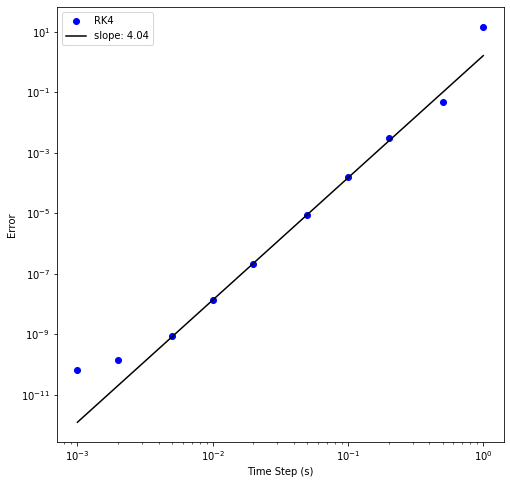

In [4]:
compare_num_to_analytic()

0.001
0.002
0.005
0.01
0.02
0.05
0.1
0.2
0.5
1


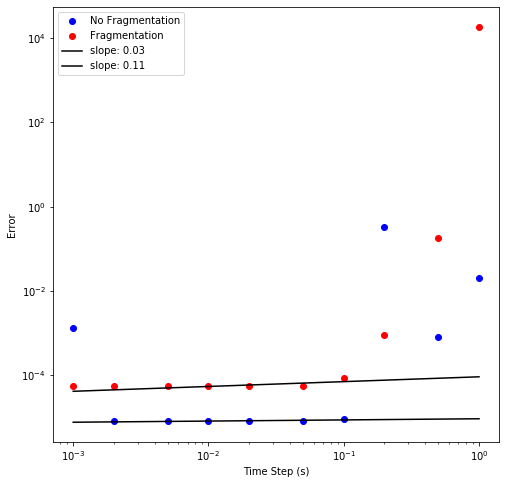

In [5]:
compare_with_scipy(alpha=0.3)